<a href="https://colab.research.google.com/github/natasaivic/ml/blob/main/telco_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

##Gather Data 

In [ ]:
telco_data =  pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/Telco-Customer-Churn.csv')
telco_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# CustomerID is not a relevant column, I will exclude it from the dataset. 
telco_data.customerID.isnull().sum() # 0
telco_data.drop(columns = 'customerID', inplace = True)

In [ ]:
telco_data.info()
#.TotalCharges.astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5070 entries, 0 to 5069
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5070 non-null   object 
 1   SeniorCitizen     5070 non-null   int64  
 2   Partner           5070 non-null   object 
 3   Dependents        5070 non-null   object 
 4   tenure            5070 non-null   int64  
 5   PhoneService      5070 non-null   object 
 6   MultipleLines     5070 non-null   object 
 7   InternetService   5070 non-null   object 
 8   OnlineSecurity    5070 non-null   object 
 9   OnlineBackup      5070 non-null   object 
 10  DeviceProtection  5070 non-null   object 
 11  TechSupport       5070 non-null   object 
 12  StreamingTV       5070 non-null   object 
 13  StreamingMovies   5070 non-null   object 
 14  Contract          5070 non-null   object 
 15  PaperlessBilling  5070 non-null   object 
 16  PaymentMethod     5070 non-null   object 


**Dataset Shape:** 
  * 20 columns 
  * 5070 rows 

**Data types:** 
  * float64(1)
  * int64(2) 
  * object(17)

# Examining numerical data 
Initially, the numerical variables are: ['SeniorCitizen', 'tenure']. 
# Reasoning 
* SeniorCitizen is a binary variable.
* TotalCharges (object) should be numerical. (Initially, it is a string, it must be a numeric to make it useful for our statistics. )
* MonthlyCharges (float64) should be numerical. 
# Conclusion 
The numerical variables should finally be: ['tenure', 'TotalCharges', 'MonthlyCharges']

In [ ]:
numerical_cols = telco_data.columns[telco_data.dtypes=='int64'].tolist()
numerical_cols 

['SeniorCitizen', 'tenure']

In [ ]:
telco_data['SeniorCitizen'].value_counts() 

0    4259
1     811
Name: SeniorCitizen, dtype: int64

In [ ]:
telco_data.SeniorCitizen = telco_data.SeniorCitizen.replace({0:"No", 1:"Yes"})

In [ ]:
telco_data['SeniorCitizen'].value_counts() 

No     4259
Yes     811
Name: SeniorCitizen, dtype: int64

In [ ]:
telco_data['tenure'].value_counts() 

1     440
72    276
2     181
3     141
4     133
     ... 
39     39
59     39
36     35
44     33
0       8
Name: tenure, Length: 73, dtype: int64

In [ ]:
# TotalCharges(object) has 8 missing values. 
telco_data['TotalCharges'].value_counts()

          8
19.75     7
20.2      7
20.15     6
19.45     6
         ..
118.25    1
1799.3    1
223.6     1
184.65    1
1816.2    1
Name: TotalCharges, Length: 4774, dtype: int64

In [ ]:
telco_data.TotalCharges.isna().any() # False
telco_data.TotalCharges.isnull().any() # False 
telco_data.TotalCharges.isna().sum() # 0

0

In [ ]:
pd.to_numeric(telco_data.TotalCharges, errors='coerce')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
5065     847.80
5066    2390.45
5067    1923.50
5068    1493.20
5069     338.10
Name: TotalCharges, Length: 5070, dtype: float64

In [ ]:
# It has 8 missing values. 
pd.to_numeric(telco_data.TotalCharges, errors='coerce').isna().sum()

8

In [ ]:
telco_data[telco_data.TotalCharges==" "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No


In [ ]:
telco_data = telco_data.drop([488, 753, 936, 1082, 1340, 3331, 3826, 4380])

In [ ]:
numerical_cols_1 = telco_data.columns[telco_data.dtypes=='int64'].tolist()
numerical_cols_1 

['tenure']

In [ ]:
telco_data['tenure'].describe().round(2)

count    5062.00
mean       32.28
std        24.61
min         1.00
25%         9.00
50%        29.00
75%        55.00
max        72.00
Name: tenure, dtype: float64

In [ ]:
# SeniorCitizen is a binary variable now. 
telco_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5062 entries, 0 to 5069
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5062 non-null   object 
 1   SeniorCitizen     5062 non-null   object 
 2   Partner           5062 non-null   object 
 3   Dependents        5062 non-null   object 
 4   tenure            5062 non-null   int64  
 5   PhoneService      5062 non-null   object 
 6   MultipleLines     5062 non-null   object 
 7   InternetService   5062 non-null   object 
 8   OnlineSecurity    5062 non-null   object 
 9   OnlineBackup      5062 non-null   object 
 10  DeviceProtection  5062 non-null   object 
 11  TechSupport       5062 non-null   object 
 12  StreamingTV       5062 non-null   object 
 13  StreamingMovies   5062 non-null   object 
 14  Contract          5062 non-null   object 
 15  PaperlessBilling  5062 non-null   object 
 16  PaymentMethod     5062 non-null   object 


In [ ]:
telco_data.shape

(5062, 20)

In [ ]:
telco_data.TotalCharges = telco_data.TotalCharges.astype('float64')
telco_data.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [ ]:
telco_data['TotalCharges'].describe().round(2)

count    5062.00
mean     2271.47
std      2266.91
min        18.80
25%       388.72
50%      1394.80
75%      3741.34
max      8684.80
Name: TotalCharges, dtype: float64

In [ ]:
numerical_cols_final = telco_data.select_dtypes(include = 'number').columns 
numerical_cols_final 
# ['tenure', 'MonthlyCharges', 'TotalCharges']

categorical_cols = telco_data.select_dtypes(exclude= 'number').columns 
categorical_cols

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [ ]:
telco_data[numerical_cols_final].describe().round(2)

,tenure,MonthlyCharges,TotalCharges
count,5062.00,5062.00,5062.00
mean,32.28,64.80,2271.47
std,24.61,30.14,2266.91
min,1.00,18.25,18.80
25%,9.00,35.50,388.72
50%,29.00,70.40,1394.80
75%,55.00,89.95,3741.34
max,72.00,118.75,8684.80


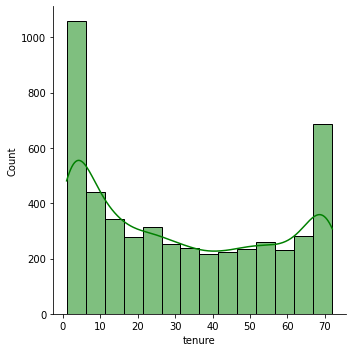

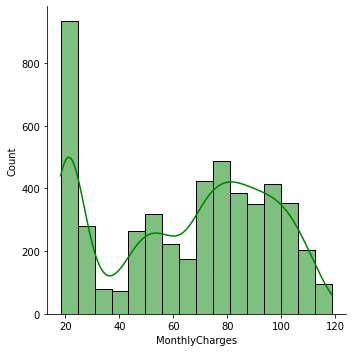

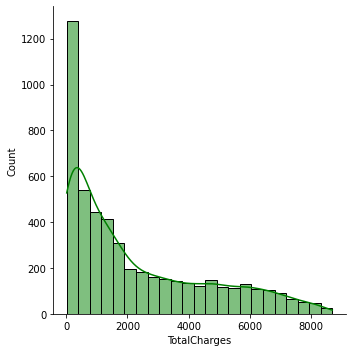

In [ ]:
# Plot the distribution with a histogram and the distribution fit:
for i in range(len(numerical_cols_final)): 
  sns.displot(data = telco_data, x = numerical_cols_final[i], kde=True, color='green')

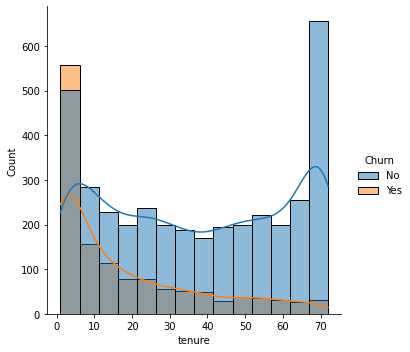

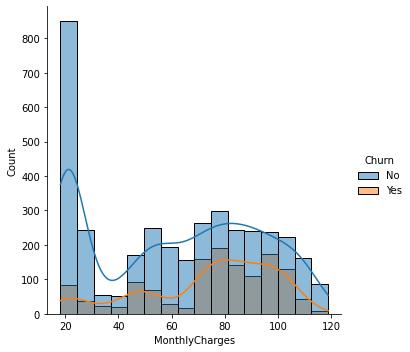

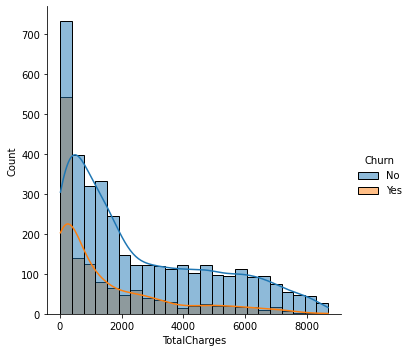

In [ ]:
# Compare the relationshipp between Churn variable and each numerical variable
for i in range(len(numerical_cols_final)): 
  sns.displot(x=numerical_cols_final[i],data=telco_data,hue='Churn', kde=True) 

# Examining categorical data

* gender
* SeniorCitizen 
* Partner
* Dependents
* PhoneService 
* PaperlessBilling 
* Churn (Turn to Binary)

# multi_valued_colmmns
* MultipleLines (Yes, No, No phone service)
* InternetService (Fiber optic, DSL, No)
* OnlineSecurity (Yes, No, No internet service)
* OnlineBackup (Yes, No, No internet service)
* DeviceProtection (Yes, No, No internet service)
* TechSupport (Yes, No, No internet service)
* StreamingTV (Yes, No, No internet service)
* StreamingMovies (Yes, No, No internet service)
* Contract (Month-to-month, Two year, One year)
* PaymentMethod (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* TotalCharges (must be shifted to numerical. Done.)


In [ ]:
single_valued_colmmns = telco_data[categorical_cols].nunique()[telco_data[categorical_cols].nunique() == 1].index.tolist()
single_valued_colmmns 

[]

In [ ]:
multi_valued_colmmns = telco_data[categorical_cols].nunique()[telco_data[categorical_cols].nunique() > 2].index.to_list()
multi_valued_colmmns

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [ ]:
telco_data['MultipleLines'].value_counts() 
telco_data['InternetService'].value_counts() 
telco_data['OnlineSecurity'].value_counts() 
telco_data['OnlineBackup'].value_counts() 
telco_data['DeviceProtection'].value_counts() 
telco_data['TechSupport'].value_counts() 
telco_data['StreamingTV'].value_counts() 
telco_data['StreamingMovies'].value_counts() 
telco_data['Contract'].value_counts() 
telco_data['PaymentMethod'].value_counts() 

Electronic check             1691
Mailed check                 1147
Bank transfer (automatic)    1115
Credit card (automatic)      1109
Name: PaymentMethod, dtype: int64

In [ ]:
binary_colmmns = telco_data[categorical_cols].nunique()[telco_data[categorical_cols].nunique() == 2].index.tolist()
binary_colmmns 

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [ ]:
# Replacing 'Yes' and 'No' with numerical values and override the column. 
telco_data.Churn = telco_data.Churn.replace({'Yes':1, 'No':0}) 

In [ ]:
telco_data.Churn.value_counts()

0    3730
1    1332
Name: Churn, dtype: int64

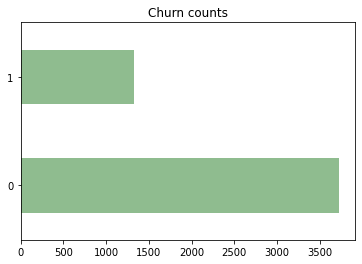

In [ ]:
telco_data.Churn.value_counts().plot(kind='barh', title='Churn counts', color = 'darkseagreen')
plt.show() 

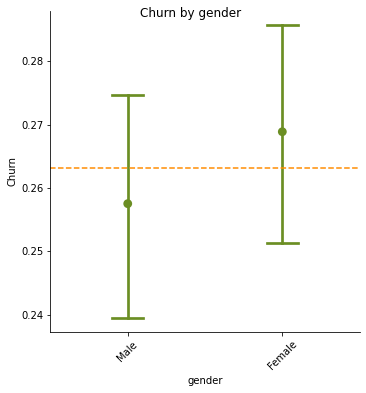

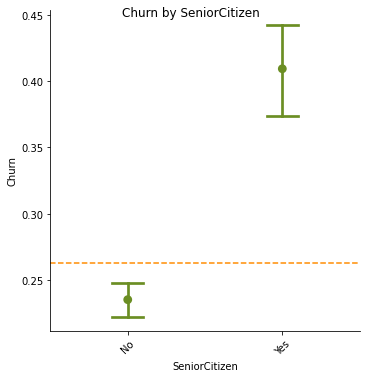

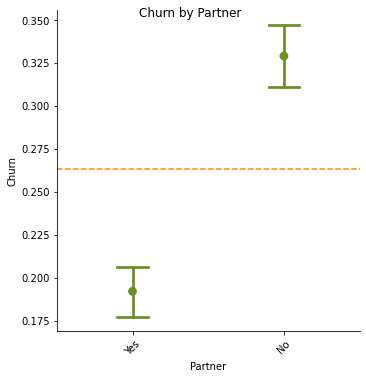

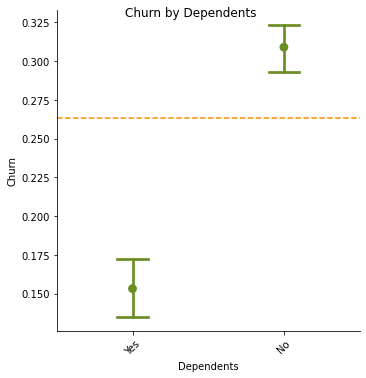

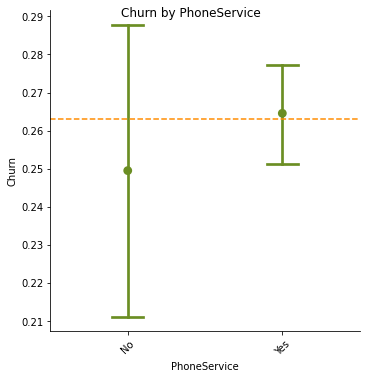

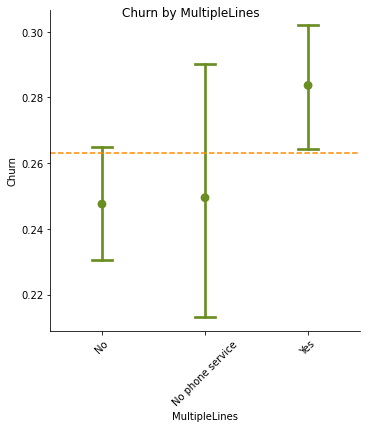

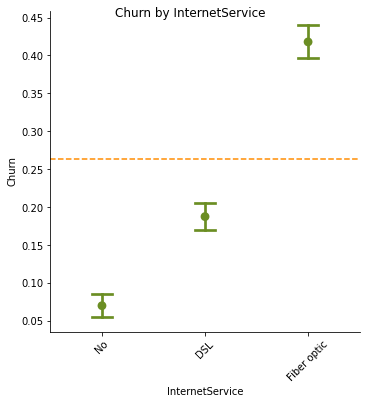

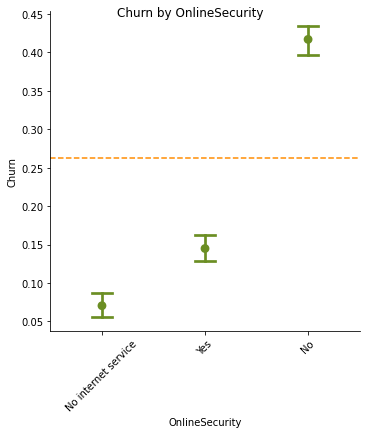

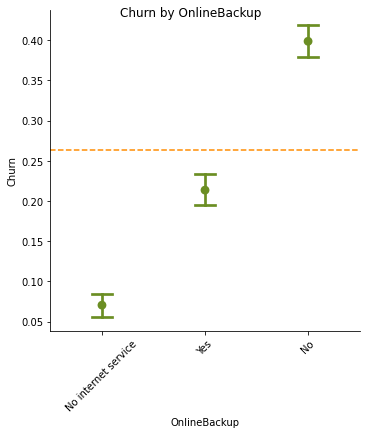

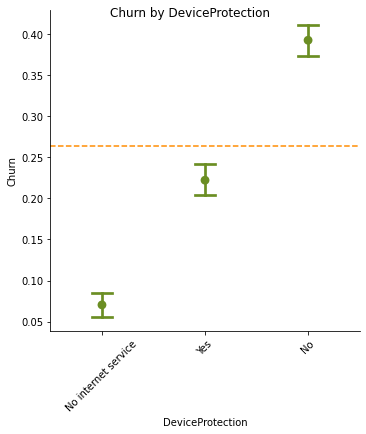

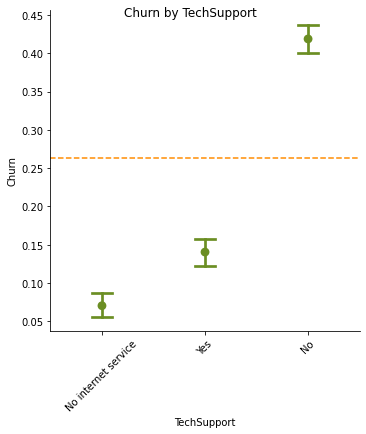

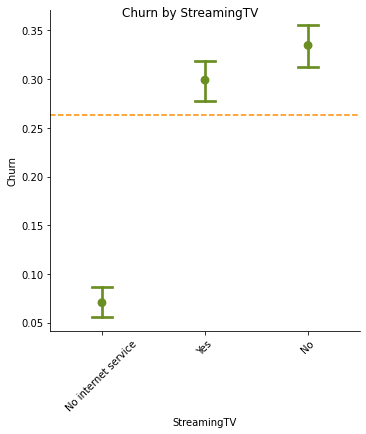

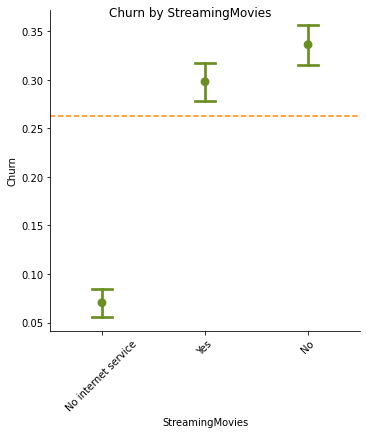

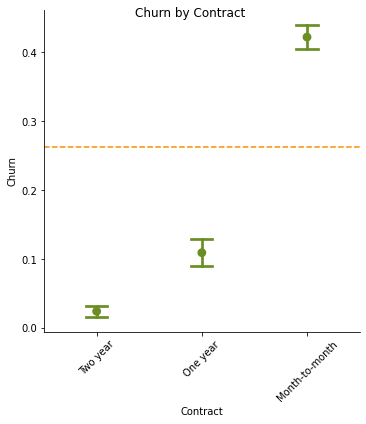

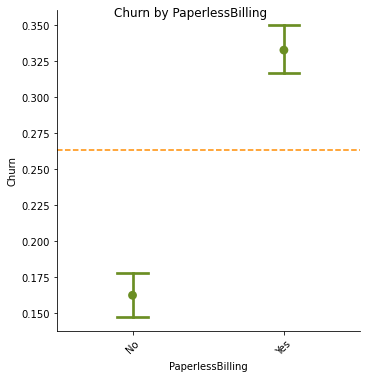

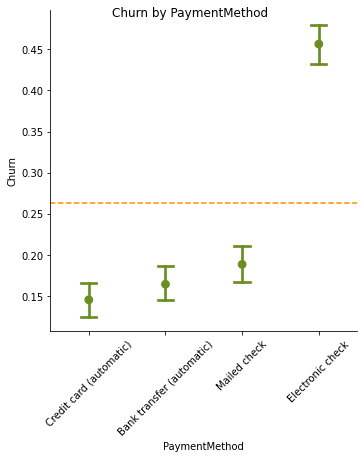

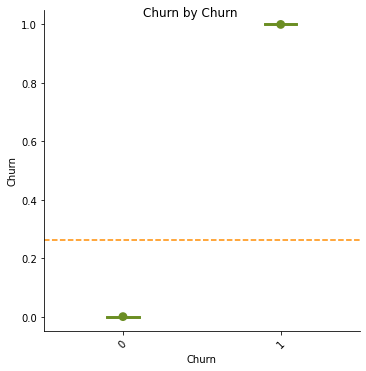

In [ ]:
# Plot the relationship between average churn and categorical variables
mean_churn = np.mean(telco_data.Churn)

def plot_categorical(x_feature, y_feature = 'Churn'):
  g = sns.catplot(
      y = y_feature,
      x = x_feature,
      data = telco_data,
      kind = 'point',
      join = False,
      estimator = np.mean,
      capsize=.2,
      order = telco_data.groupby(x_feature)['Churn'].mean().sort_values().index,
      height=5, 
      color='olivedrab')
  g.map(plt.axhline, y = mean_churn, ls='--', c='darkorange')
  g.set_xticklabels(rotation=45)
  g.set_ylabels('Churn')
  g.set_xlabels(x_feature)
  g.fig.suptitle('Churn by ' + x_feature)
  return g  

for variable in categorical_cols:
  plot_categorical(variable)

In [ ]:
# categorical_cols = telco_data.select_dtypes(exclude= 'number').columns 
# Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
#        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
#        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
#        'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
#       dtype='object') 

categorical_cols = categorical_cols.drop('Churn')
categorical_cols

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [ ]:
telco_data_categorical = telco_data[categorical_cols]
telco_data_categorical.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [ ]:
telco_data_categorical_with_dummies = pd.get_dummies(telco_data_categorical) 
telco_data_categorical_with_dummies.head()

,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [ ]:
telco_data_categorical_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5062 entries, 0 to 5069
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   gender_Female                            5062 non-null   uint8
 1   gender_Male                              5062 non-null   uint8
 2   SeniorCitizen_No                         5062 non-null   uint8
 3   SeniorCitizen_Yes                        5062 non-null   uint8
 4   Partner_No                               5062 non-null   uint8
 5   Partner_Yes                              5062 non-null   uint8
 6   Dependents_No                            5062 non-null   uint8
 7   Dependents_Yes                           5062 non-null   uint8
 8   PhoneService_No                          5062 non-null   uint8
 9   PhoneService_Yes                         5062 non-null   uint8
 10  MultipleLines_No                         5062 non-null   uint8
 11  Mult

In [ ]:
# X = pd.join([numerical_cols_final, telco_data_categorical_with_dummies], axis =1)

#  pd.concat([telco_data[numerical_cols_final], telco_data_categorical_with_dummies], axis=1)
X = telco_data[numerical_cols_final].join(telco_data_categorical_with_dummies)

In [ ]:
X

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,33,24.90,847.80,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0
5066,44,54.30,2390.45,0,1,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0
5067,30,66.30,1923.50,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0
5068,71,20.90,1493.20,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0


# Splitting data

In [ ]:
y = telco_data.pop('Churn') 

# X = telco_data[['tenure', 'MonthlyCharges', 'TotalCharges']] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
X_train.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2763,64,81.05,5135.35,0,1,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
677,2,34.70,62.25,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0
4025,4,74.80,321.90,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0
2839,41,19.30,772.40,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0
287,1,70.00,70.00,0,1,1,0,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0


# Fitting model

In [ ]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Evaluating model

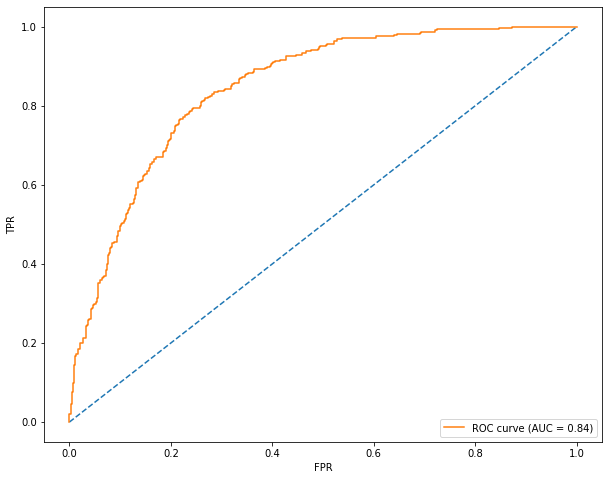

In [ ]:
# calculate scores
auc = roc_auc_score(y_test, predictions)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(10, 8))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

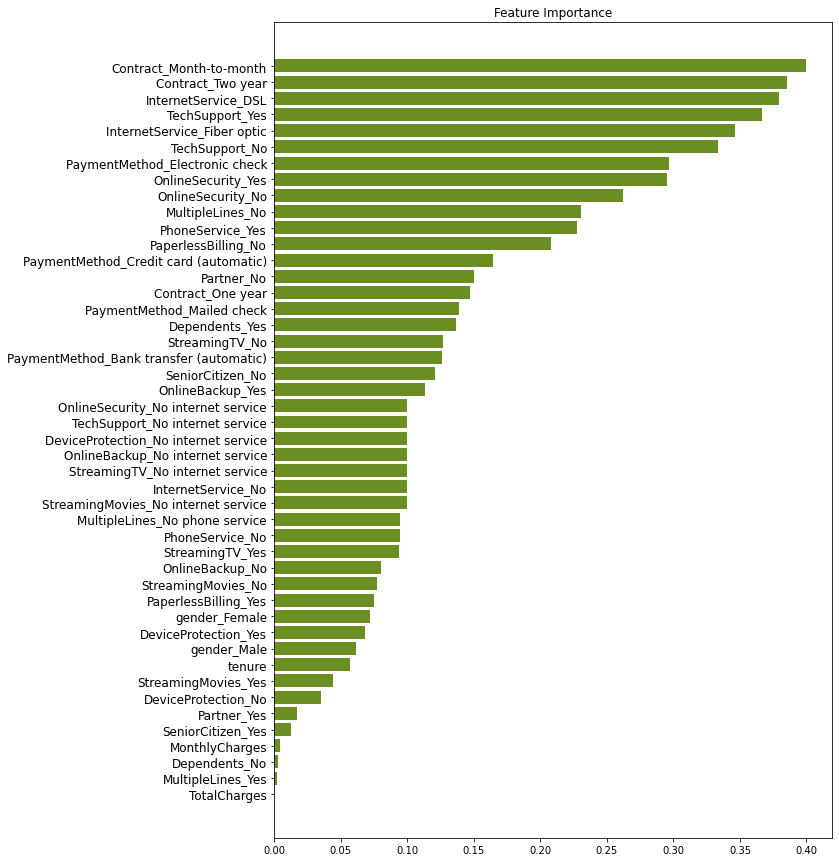

In [ ]:
feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10, 15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='olivedrab')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=12)
plt.title('Feature Importance')
plt.show()